# GSSR
Gene Splice Site Recognition by WAM, Bayesian Network and SVM approaches

## Abstract
xxx

## Introduction

### Gene splice site

https://en.wikipedia.org/wiki/RNA_splicing

RNA splicing, in molecular biology, is a form of RNA processing in which a newly made precursor messenger RNA (pre-mRNA) transcript is transformed into a mature messenger RNA (mRNA). During splicing, introns (Non-coding regions) are removed and exons (Coding Regions) are joined together. For nuclear-encoded genes, splicing takes place within the nucleus either during or immediately after transcription. For those eukaryotic genes that contain introns, splicing is usually required in order to create an mRNA molecule that can be translated into protein. For many eukaryotic introns, splicing is carried out in a series of reactions which are catalyzed by the spliceosome, a complex of small nuclear ribonucleo proteins (snRNPs). Self-splicing introns, or ribozymes capable of catalyzing their own excision from their parent RNA molecule, also exist.

### Models

https://academic.oup.com/bioinformatics/article-abstract/9/5/499/349215?redirectedFrom=PDF

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-477

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-8-S10-S7

and others

### Scikit-learn and Pgmpy

introductions of Scipy and Pgmpy

## Material and Method

### Environment

In [1]:
import warnings
import import_ipynb
import numpy as np
import pandas as pd
import networkx as nx
from Utils import load_data
from Models import WAM, BN, SVM
from Evaluator import Evaluator
from matplotlib import pyplot as plt
from IPython.display import display, Markdown
from pgmpy.estimators import MmhcEstimator, ConstraintBasedEstimator

warnings.filterwarnings("ignore")
training_set, testing_set = load_data()

importing Jupyter notebook from Utils.ipynb
importing Jupyter notebook from Models.ipynb


/home/chonghui/envs/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


importing Jupyter notebook from Evaluator.ipynb


### Data curation

### Encoding for features

When encoding the sequence features to be numeric, a One-hot encoder were used. And to make the problem simpler, the ambiguous bases in sequences were disgarded. A simple example is that when deeling with sequence A, which can be represented as $acgtay^* aaccggttr^* y^* $, the ambiguous bases $y^*$ and $r^*$ are simply disgarded. So the sequence A becomes $acgtaaaccggtt$. And next, a One-hot encoder are used to encode sequence A to a numeric feature vector, which can be represented as $[1,0,0,0...0,0,0,1]$. In all of my experiments, I used 10 bases before and after the site to be tested, including its own sequence with a total length of 21.

### Model implements

The 3 models are mainly implemented using Python. Besides, the Bayesian network model and Support vector machine were implemented based on Pgmpy and Scikit-learn pacakge. The 3 models are designed to be *[put into practical use]* as much as possible. They contain several very easy-to-use program interfaces: `fit`, `predict_probas`, `predict_scores` and `predict_classes`. For all 3 models, the `fit` method are used for training, and the other 3 `predict` methods are used for prediction. The `predict_probas` are used for predicting the probabilities each sample belonging to each class, the `predict_scores` are used for calculating the $S(X)$, and the `predict_classes` are used for predicting the classes each sample belongs, this is simply done by comparing the $S(X)$ and given threshold $T$. Most importantly, the $S(X)$ are calculated by:
$$\tag{1}S(X) = ln(\frac{P^+ (X)}{P^- {X}})$$

#### Stratagies for WAM to perform recognition

When recoginizing Gene Splice Site, the 3 steps were mainly used to determine the potential of each sample being a splice site. Firstly, Laplace Pseudocounts are used to [...]. Secondly, the weights of positive and negative submodels, which are the frequencies of adjacent base pairs in WAM, are calculated using the following formula.
$$\tag{2} f(x) = \frac{C_{x,p}+C_p}{N},x \in [aa,ac,ag,...tt]$$ where $N$ is the total number of samples. $C_{x,p}$ is the total number of specific adjacent base pairs occuring at position $p-l+1...p$ in all samples. $C_p$ is the pseudocount, and $l$ is the length of array considered, which refers to the range of dependence between adjacent base pairs considered in experiments. And finally, the potential of new samples being a donor site can be easily calculated by
$$\tag{3} S(X) = ln(\frac{P^+(X)}{P^-(X)}) = \sum_{x=2}^{L}{ln(\frac{f^+(x)}{f^-(x)})}$$
where $L$ is the length of input sequence.
Most importantly, $l$ and $C_p$ are set to $2$ and $0.5$ respectively. 

#### Stratagies for BN to learn structures and parameters from data

The min max hill climb (MMHC) algorithm *[REF]* were mainly used to learn BN structures from the training data. MMHC algorithm is a constrained-based learning algorithm, firstly be proposed by *[AUTHOR]*. *[ details of MMHC algorithm]*

#### Settings for SVM to classify splice sites

In the experiment, Gaussian Kernel function (see below) were used to map vectors to higher-dimensional feature space. The 惩罚系数 $C$ are used to .... And the key parameter $\gamma$ for Gaussian Kernel are set to [real gamma].
$$\tag{4}K(x_i, x_j) = exp(-\gamma||x_i - x_j||^2), \gamma > 0$$

In [2]:
class Model:
    
    def __init__(self):
        self.wam = WAM()
        self.bn = BN(struc_estr=MmhcEstimator)
        self.svm = SVM(kernel='rbf', gamma='scale', random_state=1, probability=True, verbose=True)
        
model = Model()

### Evaluation

To visualize and compare classification results of 3 models, the ROC Curves and Sn-Sp Curves are plotted using matplotlib package. To realize this, a sample-based benchmarking method is introduced.

$$ 
\begin{align} 
TP_t = \sum_{i\in S_{TP,t}} 1, \quad S_{TP,t}& =\{i\mid S_i\geq t \land L_i = 1\} \tag{} \\
FP_t = \sum_{i\in S_{FP,t}} 1, \quad S_{FP,t}& =\{i\mid S_i\geq t \land L_i = 0\} \tag{} \\
TN_t = \sum_{i\in S_{TN,t}} 1, \quad S_{TN,t}& =\{i\mid S_i< t \land L_i = 0\} \tag{} \\
FN_t = \sum_{i\in S_{FN,t}} 1, \quad S_{FN,t}& =\{i\mid S_i< t \land L_i = 1\} \tag{} \\
\end{align}
$$
$$
\begin{align} 
TPR_t & = \frac{TP_t}{TP_t+FN_t} \tag{} \\
FPR_t & = \frac{FP_t}{FP_t+TN_t} \tag{} \\
Sn_t & = \frac{TP_t}{TP_t+FN_t} \tag{} \\
Sp_t & = \frac{TN_t}{TN_t+FP_t} \tag{} \\
\end{align}
$$

where $ $ is ...... Finally, the ROC_AUC ( area under the ROC curve) were calculated using Composite Trapezoidal rule [ref]

$$
AUC = \sum_{i=1}^N \frac{(FPR_{i+1} - FPR_i)(TPR_i+TPR_{i+1})}{2} \tag{} \\
$$

https://github.com/scikit-learn/scikit-learn/blob/fd237278e/sklearn/metrics/_ranking.py#L42

https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.trapz.html

https://github.com/numpy/numpy/blob/v1.16.2/numpy/lib/function_base.py#L3982-L4070


## Result and Discussion

### Weights for WAM

In [3]:
#display(training_set)
model.wam.fit(training_set['Seq. features'], training_set['IsDonor'])
pd.set_option('display.max_columns', None)
p_rename = lambda x: 'P.{}'.format(x)
n_rename = lambda x: 'N.{}'.format(x)

processing...:   0%|          | 0/16 [00:00<?, ?it/s]

Fitting model with positive data...


processing...:   0%|          | 0/16 [00:00<?, ?it/s]

Fitting model with negative data...


processing...: 100%|██████████| 16/16 [04:02<00:00, 15.14s/it]


In [4]:
display(Markdown( '<h3 align="center">Weights for Weighted array model (Positive / Negative)</h3>' ))
model.wam.positive_weights.applymap(lambda x: '%.3f'%x) + '/' + \
model.wam.negative_weights.applymap(lambda x: '%.3f'%x)

<h3 align="center">Weights for Weighted array model (Positive / Negative)</h3>

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
0,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan
1,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan,nan/nan
2,0.056/0.068,0.048/0.052,0.031/0.051,0.063/0.051,0.086/0.050,0.115/0.068,0.056/0.051,0.060/0.053,0.067/0.051,0.069/0.051,0.046/0.066,0.036/0.053,0.034/0.052,0.068/0.054,0.043/0.051,0.078/0.070
3,0.092/0.050,0.076/0.057,0.037/0.055,0.075/0.057,0.066/0.056,0.069/0.052,0.072/0.058,0.076/0.059,0.058/0.056,0.072/0.057,0.027/0.050,0.021/0.057,0.057/0.057,0.069/0.060,0.044/0.056,0.062/0.051
4,0.036/0.056,0.136/0.054,0.050/0.055,0.075/0.055,0.064/0.055,0.088/0.057,0.066/0.057,0.082/0.057,0.048/0.054,0.072/0.055,0.034/0.054,0.019/0.054,0.031/0.055,0.067/0.058,0.047/0.055,0.058/0.058
5,0.042/0.054,0.066/0.055,0.034/0.055,0.057/0.056,0.072/0.055,0.089/0.057,0.081/0.057,0.112/0.057,0.061/0.056,0.060/0.055,0.040/0.055,0.030/0.055,0.029/0.054,0.074/0.058,0.060/0.055,0.047/0.056
6,0.064/0.056,0.056/0.055,0.033/0.053,0.081/0.055,0.092/0.057,0.059/0.056,0.061/0.058,0.068/0.055,0.056/0.055,0.077/0.055,0.045/0.055,0.021/0.054,0.031/0.058,0.064/0.057,0.042/0.056,0.139/0.054
7,0.042/0.055,0.123/0.061,0.045/0.055,0.060/0.056,0.077/0.056,0.085/0.055,0.049/0.054,0.050/0.056,0.049/0.054,0.075/0.057,0.029/0.053,0.020/0.057,0.039/0.055,0.126/0.056,0.054/0.054,0.043/0.055
8,0.050/0.055,0.089/0.055,0.030/0.055,0.076/0.055,0.101/0.065,0.066/0.053,0.039/0.054,0.137/0.054,0.056/0.054,0.084/0.054,0.020/0.054,0.041/0.054,0.020/0.060,0.068/0.054,0.026/0.055,0.061/0.055
9,0.120/0.054,0.030/0.054,0.024/0.069,0.053/0.055,0.168/0.054,0.035/0.055,0.046/0.052,0.036/0.054,0.073/0.056,0.024/0.055,0.009/0.054,0.008/0.054,0.134/0.055,0.027/0.054,0.078/0.056,0.038/0.053


In [5]:
scores_wam = model.wam.predict_scores(testing_set['Seq. features'].apply(str.upper))

### Graph for BN

In [6]:
to_format_arr = lambda data: np.array([np.array(list(i)) for i in data])
model.bn.fit(data=to_format_arr(training_set['Seq. features']),
             label=training_set['IsDonor'].astype(int), 
             sign_level=0.01)

Performing structure learning, using estimator: `<class 'pgmpy.estimators.MmhcEstimator.MmhcEstimator'>`
Done !
Performing parameter learning, using estimator: `<class 'pgmpy.estimators.BayesianEstimator.BayesianEstimator'>`


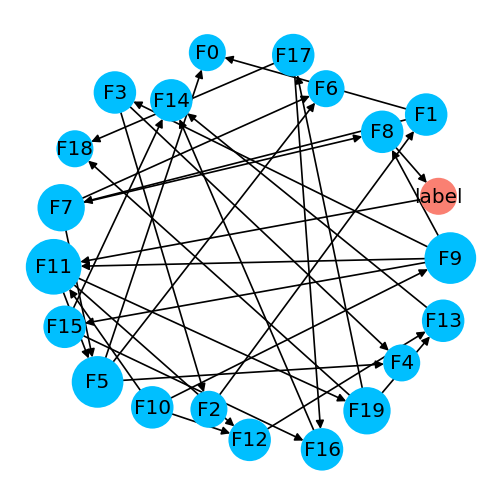

In [7]:
plt.figure(figsize=(4,4), dpi=120)
G = model.bn.networks
bicolors = ['deepskyblue','salmon']
nodesize = np.array([float(G.degree(v) + 1) for v in G])
nodecolor = np.array([bicolors[int('label' in i)] for i in G])
nx.draw(G, with_labels=True, textsize=10000, pos=nx.spring_layout(G), node_size=nodesize*150,
        node_color=nodecolor)

In [8]:
data = to_format_arr(testing_set['Seq. features'])
test_data = pd.DataFrame(data, columns=['F{}'.format(i) for i in range(data.shape[1])])
scores_bn = model.bn.predict_scores(test_data)

### Graph for SVM

In [9]:
model.svm.fit(to_format_arr(training_set['Num. features']), training_set['IsDonor'])
scores_svm = model.svm.predict_scores(to_format_arr(testing_set['Num. features']))

[LibSVM]

In [10]:
arr = to_format_arr(training_set['Num. features'])
print(arr.shape)
arr

(105280, 80)


array([[1, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1]])

### Performance
- Table
- ROC Sn-Sp Curves

In [11]:
evaltr = Evaluator(labels=testing_set['IsDonor'], 
                  wam_scores=scores_wam, 
                  bn_scores=scores_bn, 
                  svm_scores=scores_svm)

display(evaltr.Cal_Sn_Sp(evaltr.Confusion_table(T_range=np.arange(0, 10, 0.1))['wam_scores']).round(2).T)
display(evaltr.Cal_Tpr_Fpr(evaltr.Confusion_table(T_range=np.arange(0, 10, 0.1))['wam_scores']).round(2).T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Threshold,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00,1.10,1.20,1.30,1.40,1.50,1.60,1.70,1.80,1.90,2.00,2.10,2.20,2.30,2.40,2.50,2.60,2.70,2.80,2.90,3.00,3.10,3.20,3.30,3.40,3.50,3.60,3.70,3.80,3.90,4.00,4.10,4.20,4.30,4.40,4.50,4.60,4.70,4.80,4.90,5.00,5.10,5.20,5.30,5.40,5.50,5.60,5.70,5.80,5.90,6.0,6.1,6.20,6.30,6.40,6.50,6.60,6.70,6.80,6.90,7.00,7.10,7.20,7.30,7.40,7.5,7.60,7.70,7.80,7.90,8.00,8.10,8.20,8.30,8.40,8.50,8.6,8.7,8.80,8.90,9.00,9.10,9.20,9.30,9.40,9.50,9.6,9.70,9.80,9.90
Sensitivity,0.85,0.85,0.84,0.84,0.84,0.84,0.84,0.84,0.84,0.84,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.82,0.82,0.82,0.82,0.82,0.82,0.82,0.81,0.81,0.81,0.81,0.81,0.81,0.80,0.80,0.80,0.80,0.80,0.80,0.79,0.79,0.79,0.79,0.78,0.78,0.77,0.77,0.77,0.77,0.77,0.76,0.76,0.75,0.75,0.74,0.73,0.73,0.73,0.72,0.72,0.71,0.71,0.71,0.7,0.7,0.69,0.69,0.68,0.67,0.67,0.66,0.66,0.65,0.64,0.64,0.63,0.62,0.61,0.6,0.59,0.59,0.58,0.57,0.56,0.55,0.54,0.53,0.52,0.51,0.5,0.5,0.48,0.48,0.47,0.46,0.45,0.43,0.42,0.41,0.4,0.38,0.37,0.36
Specificity,0.94,0.94,0.94,0.95,0.95,0.95,0.95,0.95,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,1.00,1.00,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Threshold,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00,1.10,1.20,1.30,1.40,1.50,1.60,1.70,1.80,1.90,2.00,2.10,2.20,2.30,2.40,2.50,2.60,2.70,2.80,2.90,3.00,3.10,3.20,3.30,3.40,3.50,3.60,3.70,3.80,3.90,4.00,4.10,4.20,4.30,4.40,4.50,4.60,4.70,4.80,4.90,5.00,5.10,5.20,5.30,5.40,5.50,5.60,5.70,5.80,5.90,6.0,6.1,6.20,6.30,6.40,6.50,6.60,6.70,6.80,6.90,7.00,7.10,7.20,7.30,7.40,7.5,7.60,7.70,7.80,7.90,8.00,8.10,8.20,8.30,8.40,8.50,8.6,8.7,8.80,8.90,9.00,9.10,9.20,9.30,9.40,9.50,9.6,9.70,9.80,9.90
Tpr,0.85,0.85,0.84,0.84,0.84,0.84,0.84,0.84,0.84,0.84,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.82,0.82,0.82,0.82,0.82,0.82,0.82,0.81,0.81,0.81,0.81,0.81,0.81,0.80,0.80,0.80,0.80,0.80,0.80,0.79,0.79,0.79,0.79,0.78,0.78,0.77,0.77,0.77,0.77,0.77,0.76,0.76,0.75,0.75,0.74,0.73,0.73,0.73,0.72,0.72,0.71,0.71,0.71,0.7,0.7,0.69,0.69,0.68,0.67,0.67,0.66,0.66,0.65,0.64,0.64,0.63,0.62,0.61,0.6,0.59,0.59,0.58,0.57,0.56,0.55,0.54,0.53,0.52,0.51,0.5,0.5,0.48,0.48,0.47,0.46,0.45,0.43,0.42,0.41,0.4,0.38,0.37,0.36
Fpr,0.06,0.06,0.06,0.05,0.05,0.05,0.05,0.05,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00


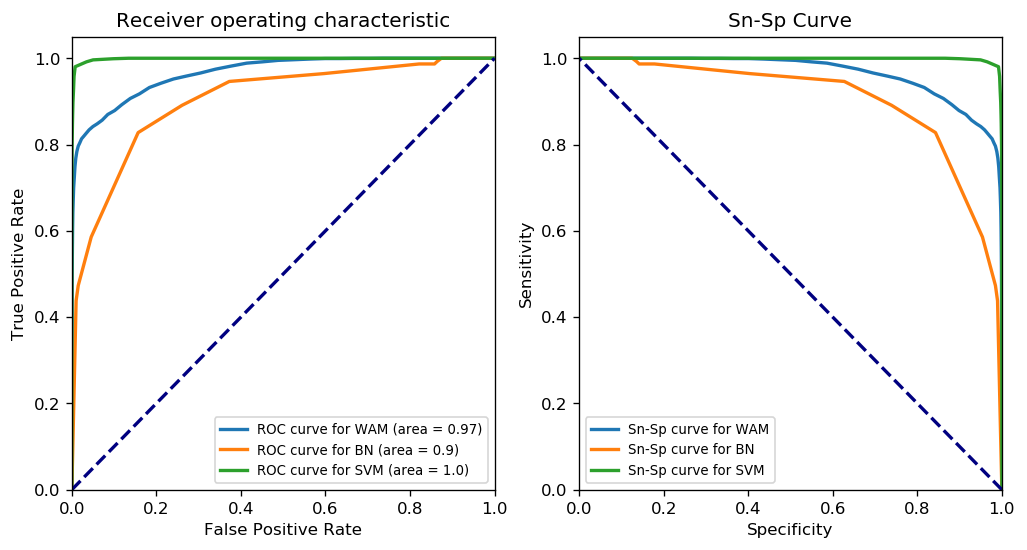

In [12]:
plt.figure(figsize=(10,5), dpi=120)
ax1 = plt.subplot(121)
evaltr.ROC_Curves(T_range=np.arange(-25, 25, 0.5))
ax1 = plt.subplot(122)
evaltr.Sn_Sp_Curves(T_range=np.arange(-25, 25, 0.5))

### Discussion

reintroduce the problem

describe results and its importance

future research